In [ ]:
%pip install ortools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


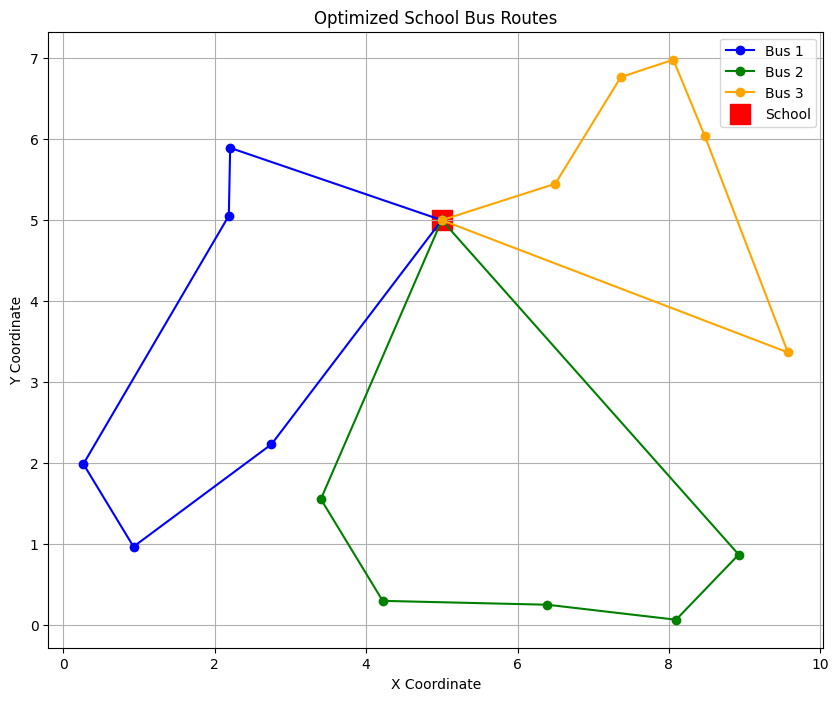

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

# Step 1: Generate Data
random.seed(42)

# School location
school = (5, 5)

# Generate 15 random students
students = [(random.uniform(0, 10), random.uniform(0, 10)) for _ in range(15)]
locations = [school] + students  # First node is school

# Step 2: Create Distance Matrix
def compute_euclidean_distance_matrix(locations):
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                distances[from_counter][to_counter] = int(
                    np.hypot((from_node[0] - to_node[0]), (from_node[1] - to_node[1])) * 100
                )  # multiply by 100 to convert to integer cm
    return distances

distance_matrix = compute_euclidean_distance_matrix(locations)

# Step 3: Define Routing Problem
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix
    data['num_vehicles'] = 3  # 3 buses
    data['depot'] = 0  # school is depot
    data['demands'] = [0] + [1] * 15  # school has demand 0, students 1
    data['vehicle_capacities'] = [5, 5, 5]  # each bus can carry 5 students
    return data

data = create_data_model()

# Create the routing index manager
manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])

# Create Routing Model
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback
def distance_callback(from_index, to_index):
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data['distance_matrix'][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

# Add Capacity constraint
def demand_callback(from_index):
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity'
)

# Setting first solution heuristic
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Solve the problem
solution = routing.SolveWithParameters(search_parameters)

# Step 4: Print and Plot the solution
def plot_solution(data, manager, routing, solution):
    routes = []
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index)
            index = solution.Value(routing.NextVar(index))
        route.append(manager.IndexToNode(index))
        routes.append(route)

    # Plot
    plt.figure(figsize=(10, 8))
    colors = ['blue', 'green', 'orange']
    for route_id, route in enumerate(routes):
        x = [locations[i][0] for i in route]
        y = [locations[i][1] for i in route]
        plt.plot(x, y, marker='o', color=colors[route_id], label=f'Bus {route_id+1}')
    plt.scatter(school[0], school[1], marker='s', color='red', s=200, label='School')
    plt.title('Optimized School Bus Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()
    plt.show()

if solution:
    plot_solution(data, manager, routing, solution)
else:
    print('No solution found!')
